# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [96]:
import tensorflow as tf
import numpy as np
import pandas as pd
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [97]:
num_classes = 10  # загальна кількість класів
num_features = 784  # кількість атрибутів вхідного вектора

learning_rate = 0.001  # швидкість навчання
training_steps = 3000  # максимальне число кроків
batch_size = 256  # розмір пакету
display_step = 100  # кожні 100 кроків показуємо прогрес

n_hidden_1 = 128  # кількість нейронів 1-го шару
n_hidden_2 = 256  # кількість нейронів 2-го шару

In [98]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо на float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо зображення в вектори
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255.0, x_test / 255.0

# Перемішуємо та підготовлюємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [99]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        initializer = tf.keras.initializers.HeNormal()  # Ініціалізація вагів методом He
        self.w = tf.Variable(initializer([in_features, out_features]), name="w")
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=None):
        y = tf.matmul(x, self.w) + self.b
        if activation:
            return activation(y)
        return y

class NN(tf.Module):
    def __init__(self, name=None):
        super().__init__(name=name)
        # Перший шар, який складається з 128 нейронів
        self.layer1 = DenseLayer(num_features, n_hidden_2)  
        self.dropout1 = tf.keras.layers.Dropout(0.5)  
        # Другий шар, який складається з 256 нейронів
        self.layer2 = DenseLayer(n_hidden_2, num_features)   
        self.dropout2 = tf.keras.layers.Dropout(0.5)   
        # Вихідний шар
        self.layer3 = DenseLayer(num_features, num_classes)


    def __call__(self, x, training=False):
    # Передача даних через перші два шари та вихідний шар з функцією активації softmax
        x = self.layer1(x, activation=tf.nn.relu)
        if training:
            x = self.dropout1(x, training=training)  # Використовуємо Dropout тільки під час тренування
        x = self.layer2(x, activation=tf.nn.relu)
        if training:
            x = self.dropout2(x, training=training)
        x = self.layer3(x)
        return tf.nn.softmax(x)  

In [100]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
# Як метрику якості використовуємо точність
def cross_entropy_loss(y_pred, y_true):
    # Перетворюємо мітки y_true в one-hot формат
    y_true = tf.one_hot(y_true, depth=num_classes)
    # Крос-ентропійна функція втрат
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred, labels=y_true))
    return loss

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    y_pred_classes = tf.argmax(y_pred, axis=1)
    correct_predictions = tf.equal(y_pred_classes, tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

In [101]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Оптимізатор (Adam)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [102]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    with tf.GradientTape() as tape:
        # Передбачення (з Dropout під час навчання)
        pred = neural_net(batch_x, training=True)
        # Обчислення втрат
        loss = cross_entropy_loss(pred, batch_y)

    # Обчислення та застосування градієнтів
    gradients = tape.gradient(loss, neural_net.trainable_variables)
    optimizer.apply_gradients(zip(gradients, neural_net.trainable_variables))

    if step % display_step == 0:
        # Під час оцінювання Dropout не використовується
        pred_eval = neural_net(batch_x, training=False)
        acc = accuracy(pred_eval, batch_y)
        loss_history.append(loss.numpy())
        accuracy_history.append(acc.numpy())
        print(f"Step {step}, Loss: {loss:.4f}, Accuracy: {acc:.4f}")

Step 100, Loss: 2.0335, Accuracy: 0.5664
Step 200, Loss: 1.7604, Accuracy: 0.7695
Step 300, Loss: 1.7313, Accuracy: 0.8945
Step 400, Loss: 1.6654, Accuracy: 0.8672
Step 500, Loss: 1.6657, Accuracy: 0.8711
Step 600, Loss: 1.6470, Accuracy: 0.8672
Step 700, Loss: 1.6141, Accuracy: 0.8945
Step 800, Loss: 1.6294, Accuracy: 0.8789
Step 900, Loss: 1.5875, Accuracy: 0.9062
Step 1000, Loss: 1.5740, Accuracy: 0.9414
Step 1100, Loss: 1.5779, Accuracy: 0.9219
Step 1200, Loss: 1.5714, Accuracy: 0.9297
Step 1300, Loss: 1.5636, Accuracy: 0.9297
Step 1400, Loss: 1.5597, Accuracy: 0.9531
Step 1500, Loss: 1.5750, Accuracy: 0.9453
Step 1600, Loss: 1.5577, Accuracy: 0.9219
Step 1700, Loss: 1.5571, Accuracy: 0.9141
Step 1800, Loss: 1.5450, Accuracy: 0.9453
Step 1900, Loss: 1.5432, Accuracy: 0.9336
Step 2000, Loss: 1.5636, Accuracy: 0.9258
Step 2100, Loss: 1.5310, Accuracy: 0.9531
Step 2200, Loss: 1.5788, Accuracy: 0.9102
Step 2300, Loss: 1.5573, Accuracy: 0.9375
Step 2400, Loss: 1.5501, Accuracy: 0.9414
S

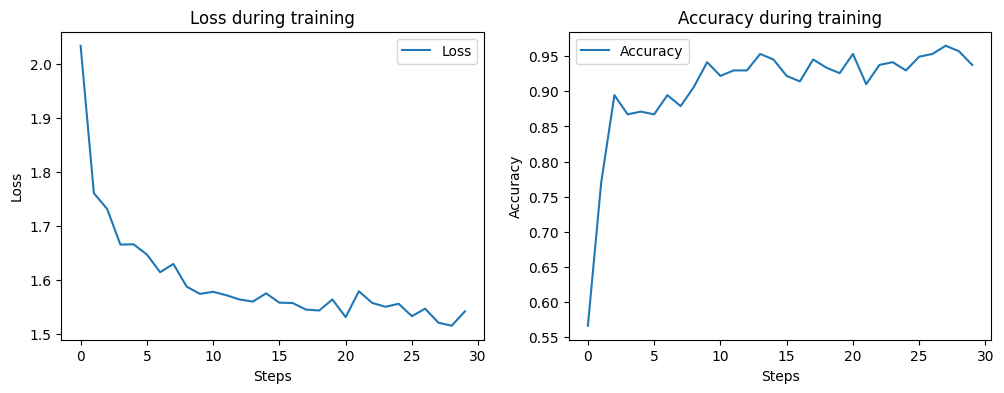

In [103]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(loss_history, label='Loss')
plt.title('Loss during training')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracy_history, label='Accuracy')
plt.title('Accuracy during training')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [104]:
# Обчисліть точність навченої нейромережі
import time

# Функція для обчислення точності на тренувальних даних
def evaluate_model(neural_net, dataset, max_batches=None):
    total_correct = 0
    total_samples = 0
    batch_count = 0
    
    start_time = time.time()  # Початок вимірювання часу
    
    for batch_x, batch_y in dataset:
        # Передбачення для кожного батчу
        predictions = neural_net(batch_x)
        # Визначаємо передбачені класи
        predicted_classes = tf.argmax(predictions, axis=1)
        # Перетворення міток у тип int64
        batch_y = tf.cast(batch_y, tf.int64)
        # Підраховуємо правильні передбачення
        correct_predictions = tf.reduce_sum(tf.cast(predicted_classes == batch_y, tf.float32))
        total_correct += correct_predictions
        total_samples += batch_x.shape[0]
        
        batch_count += 1
        # Якщо вказано max_batches, зупиняємо виконання після обробки max_batches батчів
        if max_batches and batch_count >= max_batches:
            break

    end_time = time.time()  # Кінець вимірювання часу
    print(f"Time taken: {end_time - start_time:.2f} seconds for {batch_count} batches")

    # Обчислення точності
    accuracy = total_correct / total_samples
    return accuracy.numpy()

# Оцінка точності на тренувальних даних
train_accuracy = evaluate_model(neural_net, train_data, max_batches=10000)
print(f"Train Accuracy: {train_accuracy * 100:.2f}%")

# Тестування моделі на тестових даних
# Перетворюємо тестові дані на відповідний формат і робимо передбачення
test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

# Обчислюємо точність моделі на тестових даних
test_accuracy = evaluate_model(neural_net, test_data)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Time taken: 139.26 seconds for 10000 batches
Train Accuracy: 95.02%
Time taken: 0.55 seconds for 40 batches
Test Accuracy: 95.03%


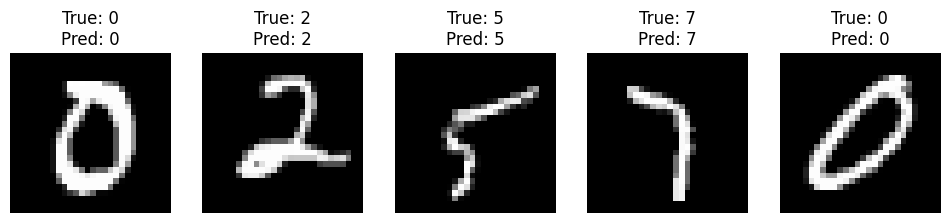

Accuracy on 5 random images: 100.00%


In [105]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.

# Функція для візуалізації тестових зображень і передбачень моделі
def test_random_images(model, test_data, num_images=5):
    # Отримання батчу тестових даних
    images, labels = next(iter(test_data))
    
    # Вибір 5 випадкових індексів
    random_indices = random.sample(range(images.shape[0]), num_images)
    
    plt.figure(figsize=(12, 6))  # Створення фігури для зображень
    
    for i, idx in enumerate(random_indices):
        image = images[idx].numpy().reshape(28, 28)  # Перетворення у формат 28x28
        label = labels[idx].numpy()

        # Передбачення нейронної мережі
        reshaped_image = images[idx].numpy().reshape(1, -1)  # Перетворення в 1D масив (784,)
        prediction = model(reshaped_image)  # Передбачення моделі
        predicted_class = np.argmax(prediction, axis=1)[0]

        # Виведення зображення
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image, cmap='gray')  # Відображення зображення у відтінках сірого
        plt.title(f"True: {label}\nPred: {predicted_class}")
        plt.axis('off')
    
    plt.show()

    # Оцінка того, як часто модель помиляється
    correct_predictions = 0
    for idx in random_indices:
        image = images[idx].numpy().reshape(1, -1)  # Перетворення на одномірний масив
        label = labels[idx].numpy()
        prediction = model(image)  # Передбачення моделі
        predicted_class = np.argmax(prediction, axis=1)[0]
        
        if predicted_class == label:
            correct_predictions += 1

    accuracy = correct_predictions / num_images
    print(f"Accuracy on {num_images} random images: {accuracy * 100:.2f}%")

# Припускаємо, що `test_data` - це тестова вибірка, а `neural_net` - навчена модель
test_random_images(neural_net, test_data)

Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

Нейронна мережа допускає помилки. З 250 зображень допущено 9 помилок, що становить 3,6 %, тобто точність 96,4% , що приблизно співпадає з показами тестування моделі на тестових даних.   